In [10]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree
from intercluster import *
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [36]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

uncovered_color = (1,1,1)
overlap_color = (0.45, 0.5, 0.5)

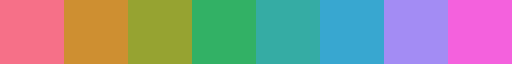

In [37]:
cmap

### Data

In [7]:
shapefile_path = '../data/climate/climate_divisions/climate_divisions.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

/Users/quinnk/Library/Caches/pypoetry/virtualenvs/intercluster-sHZsOx4e-py3.9/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


In [9]:
climate_data = pd.read_csv('../data/climate/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

In [6]:
# change months to seasons\n",
groupings = {'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
            'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
            'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
            'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
            'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
            'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
            'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
            'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)

In [11]:
unscaled_data = climate_change.to_numpy()
feature_labels = climate_change.columns

scaler = StandardScaler()
data = scaler.fit_transform(unscaled_data)

### KMeans

In [54]:
samples = 100
num_clusters_trials = np.array([2,3,4,5,6,7,8,9,10])
num_clusters_costs = np.zeros((len(num_clusters_trials), samples))

for i, nclusters in enumerate(num_clusters_trials):
    for j in range(samples):
        kmeans = KMeans(n_clusters=nclusters, n_init="auto", random_state = None).fit(data)
        kmeans_labels = labels_format(kmeans.labels_)
        kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = nclusters)
        cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment)
        num_clusters_costs[i,j] = cost

Text(0.5, 0, 'Number of clusters')

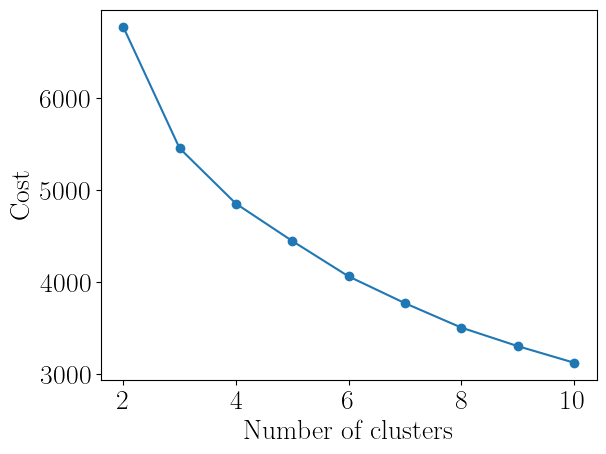

In [60]:
plt.plot(num_clusters_trials, np.mean(num_clusters_costs, axis = 1), marker = 'o')
plt.ylabel('Cost')
plt.xlabel('Number of clusters')

In [69]:
np.random.seed(342)
k = 6
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_labels = labels_format(kmeans.labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)
cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment, normalize = True)

([], [])

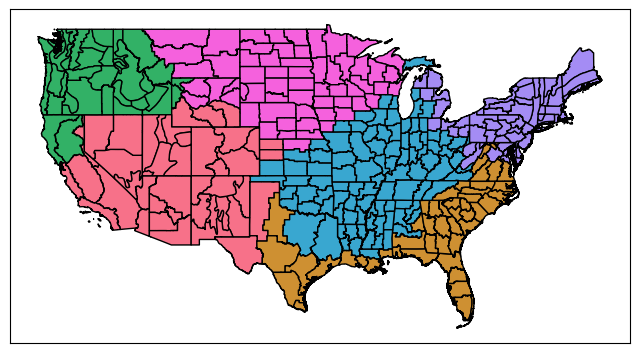

In [70]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = kmeans.labels_[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(-0.2, 1), borderaxespad=0.)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/climate/kmeans_map.png', bbox_inches = 'tight', dpi = 300)

### IMM / ExKMC

In [71]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = 7,
    imm = True, 
    feature_labels = feature_labels
)
exkmc_tree.fit(data)
exkmc_data_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_data_label_array = flatten_labels(exkmc_data_labels)
exkmc_rules, exkmc_rule_labels = get_decision_paths_with_labels(
    exkmc_tree.root,
    exkmc_data_labels,
    unique_labels(exkmc_data_labels)
)

([], [])

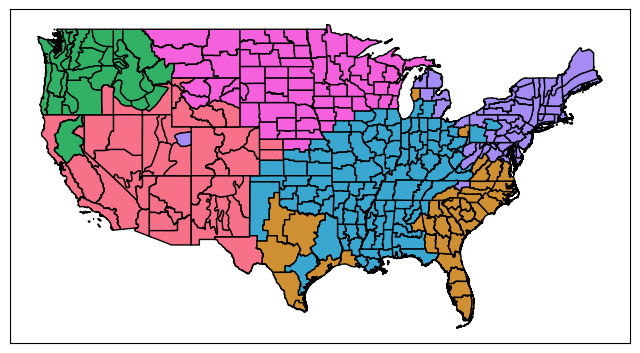

In [72]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = exkmc_data_label_array[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(-0.2, 1), borderaxespad=0.)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/climate/imm_map.png', bbox_inches = 'tight', dpi = 300)

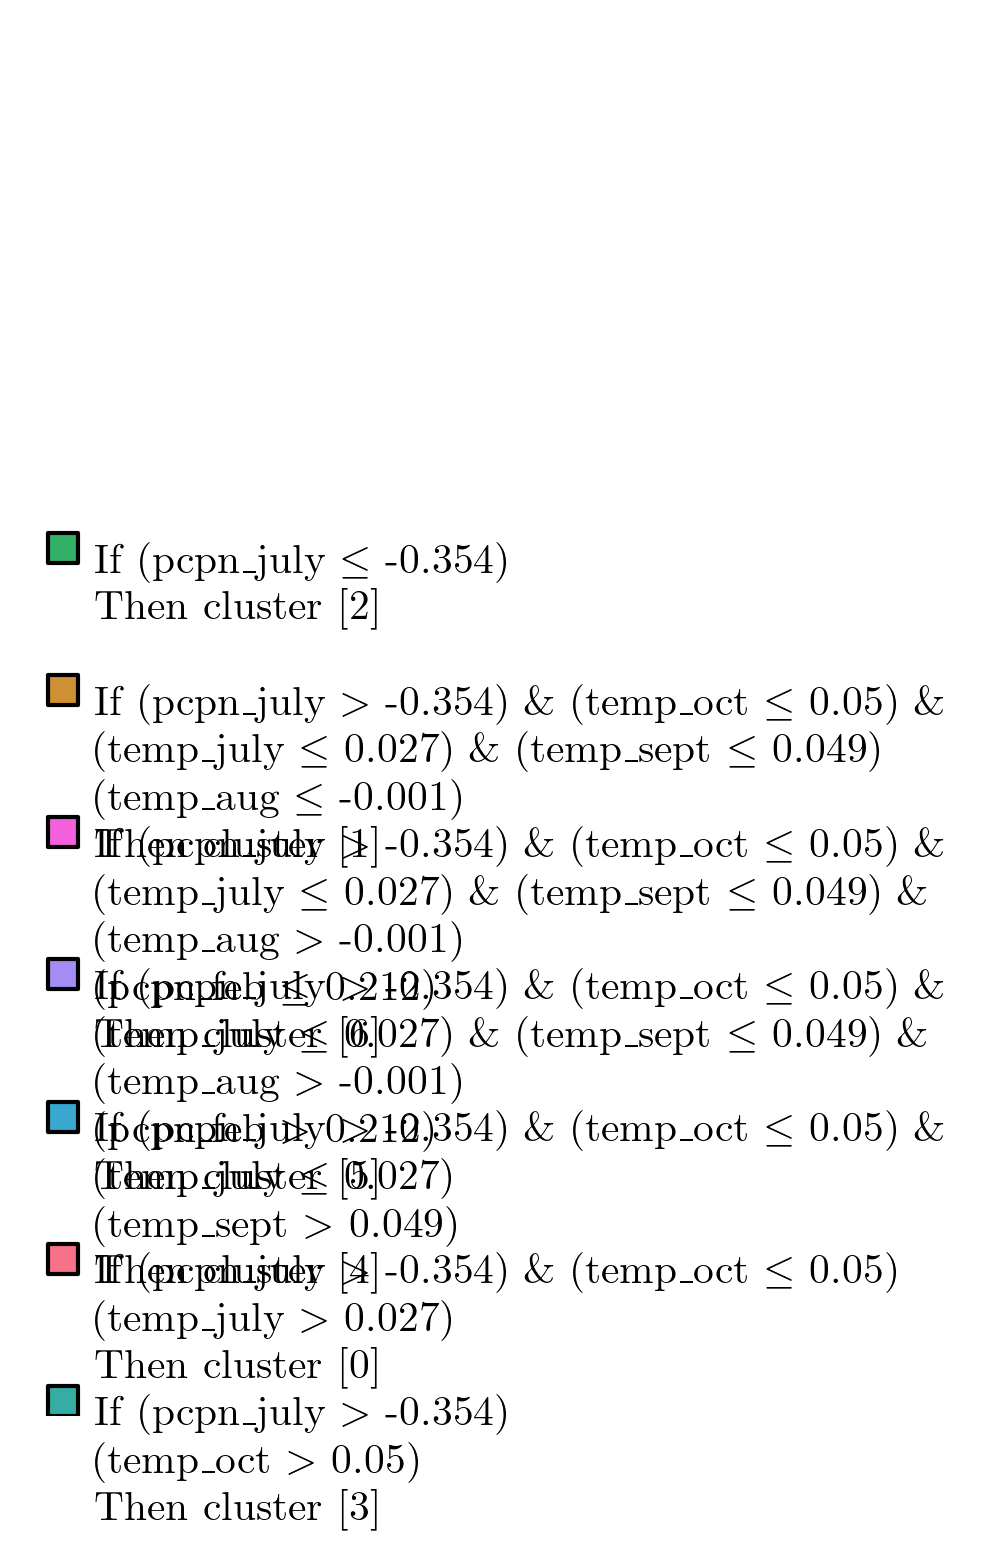

In [12]:
#fname = '../figures/climate/imm_rule_list.png'
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
exkmc_conditions = [[node.condition for node in rule[:-1]] for rule in exkmc_rules]
plot_decision_set(
    exkmc_conditions,
    feature_labels,
    exkmc_rule_labels,
    cluster_colors,
    data_scaler = scaler,
    filename = fname
)

In [16]:
#fname = '../figures/climate/imm_tree.png'
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
leaf_colors = {i:mcolors.rgb2hex(cmap_subset(i)) for i in range(k)}
visualize_tree(
    root = exkmc_tree.root,
    feature_labels = feature_labels,
    leaf_colors = leaf_colors,
    data_scaler = scaler,
    cost = False,
    output_file = 'tree'
)

AttributeError: 'StandardScaler' object has no attribute 'data_min_'

In [17]:
tree = ExTree(k, max_leaves = 14, base_tree =  'IMM')
exkmc_labels = tree.fit_predict(data, kmeans=kmeans)
exkmc_assignment = labels_to_assignment(exkmc_labels)
exkmc_centers = tree.all_centers
cost = kmeans_cost(data, exkmc_assignment, exkmc_centers, normalize = True)

TypeError: labels_to_assignment() missing 1 required positional argument: 'n_labels'

## Decision Forests

In [73]:
np.random.seed(342)

In [74]:
# Module Parameters:
k = 6
n_clusters = k
n_rules = k
frac_cover = 0.9
n_trees = 1000
data_labels = kmeans_labels
centers = kmeans.cluster_centers_


# Depth 2 Forest:
forest_tree_params_depth_2 = {
    'max_depth' : 2
}

forest_params_depth_2 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_2,
    'num_trees' : n_trees,
    'max_features' : 6,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

# Depth 5 Forest:
forest_tree_params_depth_5 = {
    'max_depth' : 5
}

forest_params_depth_5 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_5,
    'num_trees' : n_trees,
    'max_features' : 6,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

# Oblique Forest:
oblique_forest_tree_params = {
    'max_depth' : 2
}

oblique_forest_params = {
    'tree_model' : ObliqueTree,
    'tree_params' : oblique_forest_tree_params,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

In [75]:
# Create and fit the forest models
forest = DecisionForest(**forest_params_depth_2)
forest_depth_5 = DecisionForest(**forest_params_depth_5)
oblique_forest = DecisionForest(**oblique_forest_params)

forest.fit(data, kmeans_labels)
forest_depth_5.fit(data, kmeans_labels)

# Oblique takes some time to run!
oblique_forest.fit(data, kmeans_labels)

### Pruning

In [76]:
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)

prune_params = {
    'n_rules' : n_rules,
    'frac_cover' : 0.9,
    'n_clusters' : n_clusters,
    'X' : data,
    'y' : data_labels,
    'objective' : prune_objective,
    'lambda_search_range' : np.linspace(0,10,101),
    'cpu_count' : 4
}

In [77]:
forest.prune(**prune_params)
forest_depth_5.prune(**prune_params)
oblique_forest.prune(**prune_params)

forest_prune_predictions = forest.pruned_predict(data, rule_labels = False)
forest_depth_5_prune_predictions = forest_depth_5.pruned_predict(data, rule_labels = False)
oblique_forest_prune_predictions = oblique_forest.pruned_predict(data, rule_labels = False)

([], [])

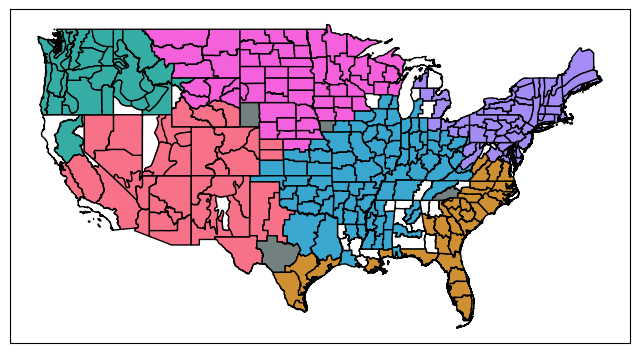

In [79]:
prune_predictions = forest_depth_5_prune_predictions
uncover_colors = subset_colors
if len([l for l in prune_predictions if len(l) > 1]) > 0:
    uncover_colors = [overlap_color] + subset_colors
if len([l for l in prune_predictions if len(l) == 0]) > 0:
    uncover_colors = [uncovered_color] + uncover_colors

cmap_subset_uncover = ListedColormap(uncover_colors)

label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = list(prune_predictions[i])
        if len(l) == 1:
            label_array[idx[0]] = l[0]
        elif len(l) > 1:
            label_array[idx[0]] = -1
        else:
            label_array[idx[0]] = -2

gdf['cluster'] = label_array
fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset_uncover, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/climate/forest_map.png', bbox_inches = 'tight', dpi = 300)

In [42]:
'''
# Plots for individual rules:
#fig,ax = plt.subplots(q, 1, figsize = (8,8*q), dpi = 100)
for r in range(7):
    r_labels = np.zeros(len(data)) - 1
    r_labels[rule_covers[selected_rules[r]]] = r
    
    label_array = np.empty(len(gdf))
    label_array[:] = np.nan
    for i,ide in enumerate(climate_change.index):
        idx = gdf.loc[gdf.CLIMDIV == ide].index
        if len(idx) == 1:
            label_array[idx[0]] = r_labels[i]

    fig,ax = plt.subplots(dpi = 100)
    c = selected_rule_labels[r]
    new_cmap = ["white", cmap_subset(c)]
    new_cmap = ListedColormap(new_cmap)
    gdf['cluster'] = label_array
    gdf.plot(column='cluster', cmap=new_cmap, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
    plt.xticks([])
    plt.yticks([]) 
    #plt.savefig('../figures/decision_sets/rule_' + str(r) + '.png', bbox_inches = 'tight', dpi = 300)
'''

'\n# Plots for individual rules:\n#fig,ax = plt.subplots(q, 1, figsize = (8,8*q), dpi = 100)\nfor r in range(7):\n    r_labels = np.zeros(len(data)) - 1\n    r_labels[rule_covers[selected_rules[r]]] = r\n    \n    label_array = np.empty(len(gdf))\n    label_array[:] = np.nan\n    for i,ide in enumerate(climate_change.index):\n        idx = gdf.loc[gdf.CLIMDIV == ide].index\n        if len(idx) == 1:\n            label_array[idx[0]] = r_labels[i]\n\n    fig,ax = plt.subplots(dpi = 100)\n    c = selected_rule_labels[r]\n    new_cmap = ["white", cmap_subset(c)]\n    new_cmap = ListedColormap(new_cmap)\n    gdf[\'cluster\'] = label_array\n    gdf.plot(column=\'cluster\', cmap=new_cmap, ax = ax, legend=False, edgecolor = \'black\', alpha = 1)\n    plt.xticks([])\n    plt.yticks([]) \n    #plt.savefig(\'../figures/decision_sets/rule_\' + str(r) + \'.png\', bbox_inches = \'tight\', dpi = 300)\n'

AttributeError: 'StandardScaler' object has no attribute 'data_min_'

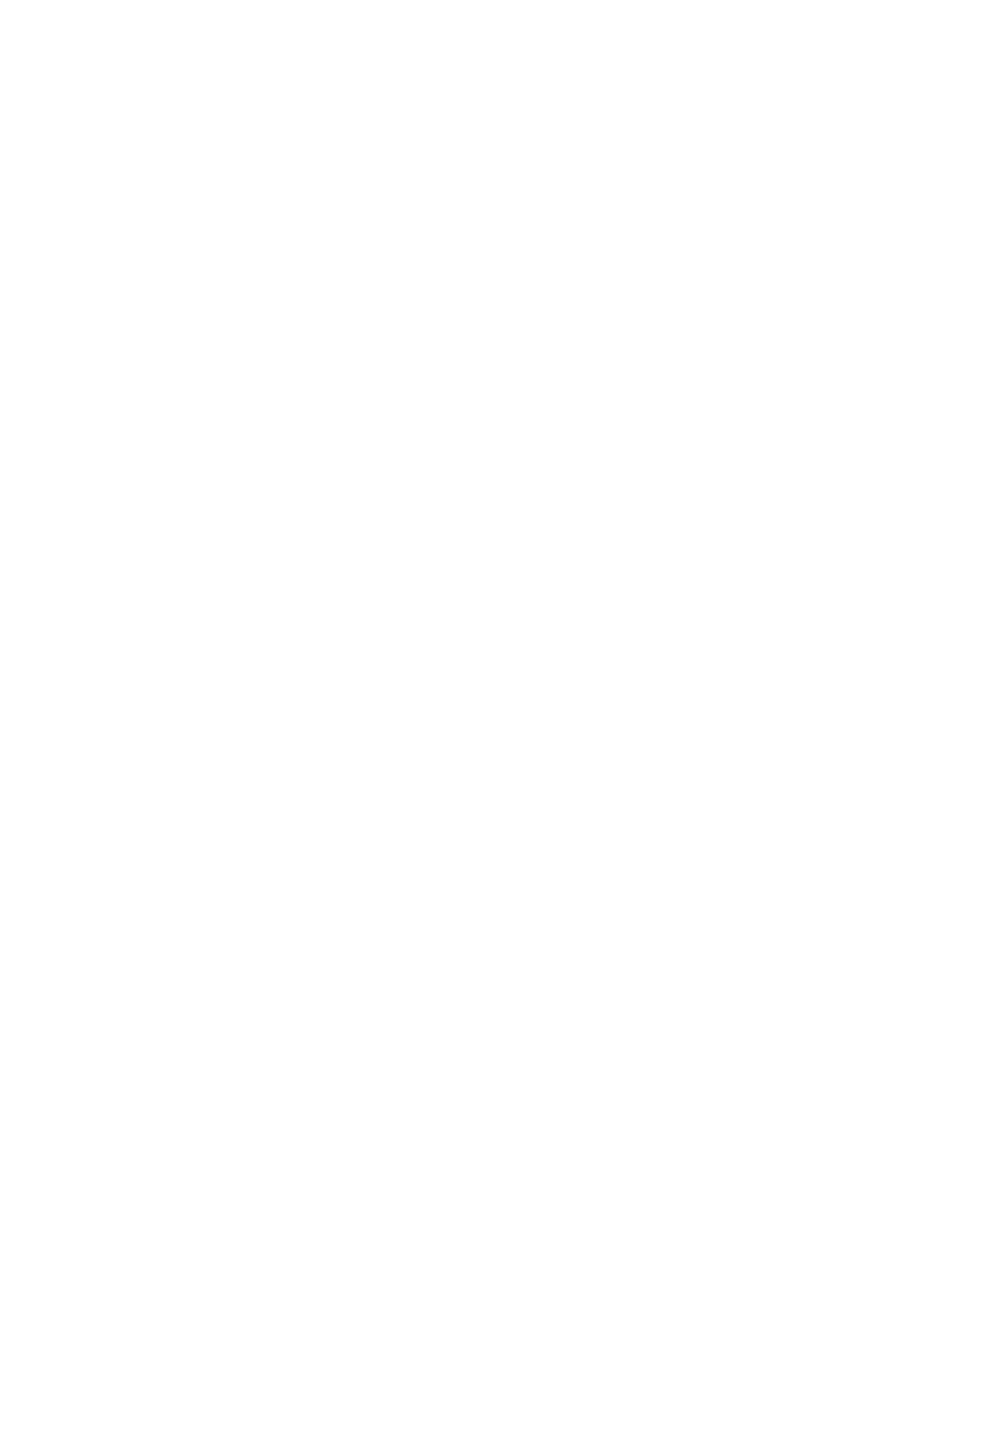

In [22]:
#fname = '../figures/climate/forest_rule_list.png'
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    [forest.decision_set[i] for i in forest.pruned_indices],
    feature_labels,
    [forest.decision_set_labels[i] for i in forest.pruned_indices],
    cluster_colors,
    data_scaler = scaler,
    filename = fname
)

### Distance Ratio Distributions

In [27]:
prune_predictions = forest_depth_5_prune_predictions
assignment = labels_to_assignment(
    prune_predictions,
    n_labels = n_clusters
)
distance_ratios = distance_ratio(data, centers)

# Single Covers:
single_cover_mask = np.sum(assignment, axis = 1) == 1
single_cover_distance_ratios = distance_ratios[single_cover_mask]

# Overlaps:
overlap_mask = np.sum(assignment, axis = 1) > 1
overlap_distance_ratios = distance_ratios[overlap_mask]

# Uncovereds:
uncovered_mask = np.sum(assignment, axis = 1) < 1
uncovered_distance_ratios = distance_ratios[uncovered_mask]

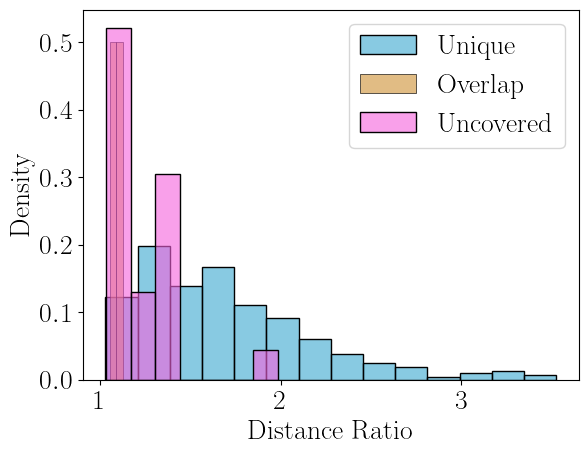

In [28]:
sns.histplot(single_cover_distance_ratios, stat = 'probability', alpha = 0.6, label = "Unique", color = cmap(5))
sns.histplot(overlap_distance_ratios, stat = 'probability', alpha = 0.6, label = "Overlap", color = cmap(1))
sns.histplot(uncovered_distance_ratios, stat = 'probability', alpha = 0.6, label = "Uncovered", color = cmap(7))
plt.ylabel("Density")
plt.xlabel("Distance Ratio")
plt.legend()

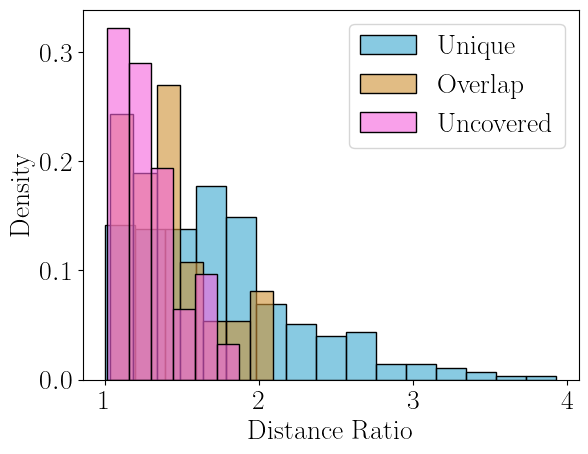

In [103]:
sns.histplot(single_cover_distance_ratios, stat = 'probability', alpha = 0.6, label = "Unique", color = cmap(5))
sns.histplot(overlap_distance_ratios, stat = 'probability', alpha = 0.6, label = "Overlap", color = cmap(1))
sns.histplot(uncovered_distance_ratios, stat = 'probability', alpha = 0.6, label = "Uncovered", color = cmap(7))
plt.ylabel("Density")
plt.xlabel("Distance Ratio")
plt.legend()

## Voronoi Sets

In [13]:
feature_pairings = [list(range(12))] + [list(range(12,24))]

vor = VoronoiSet(
    centers = kmeans.cluster_centers_, 
    num_sets = 1000,
    num_conditions = 2,
    feature_pairings = feature_pairings, 
    feature_labels = feature_labels
)
vor.fit(data, kmeans_labels)

In [14]:
prune_objective = KmeansObjective(
    X = data,
    centers = kmeans.cluster_centers_,
    normalize = True
)

vor.prune(
    n_rules = 7,
    frac_cover = 0.75,
    n_clusters = 7,
    X = data, 
    y = [[l] for l in kmeans.labels_],
    objective = prune_objective,
    lambda_search_range = np.linspace(0,10,101)
    #lambda_search_range = [10]
)
prune_predictions = vor.pruned_predict(data, rule_labels = False)

([], [])

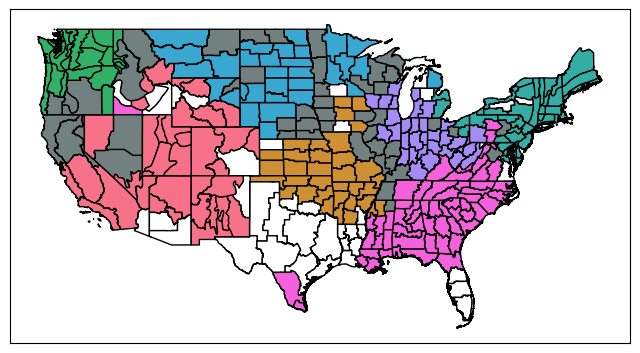

In [15]:
uncover_colors = subset_colors
if len([l for l in prune_predictions if len(l) > 1]) > 0:
    uncover_colors = [overlap_color] + subset_colors
if len([l for l in prune_predictions if len(l) == 0]) > 0:
    uncover_colors = [uncovered_color] + uncover_colors

cmap_subset_uncover = ListedColormap(uncover_colors)

label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = list(prune_predictions[i])
        if len(l) == 1:
            label_array[idx[0]] = l[0]
        elif len(l) > 1:
            label_array[idx[0]] = -1
        else:
            label_array[idx[0]] = -2

gdf['cluster'] = label_array
fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset_uncover, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/decision_sets/kmeans.png', bbox_inches = 'tight', dpi = 300)

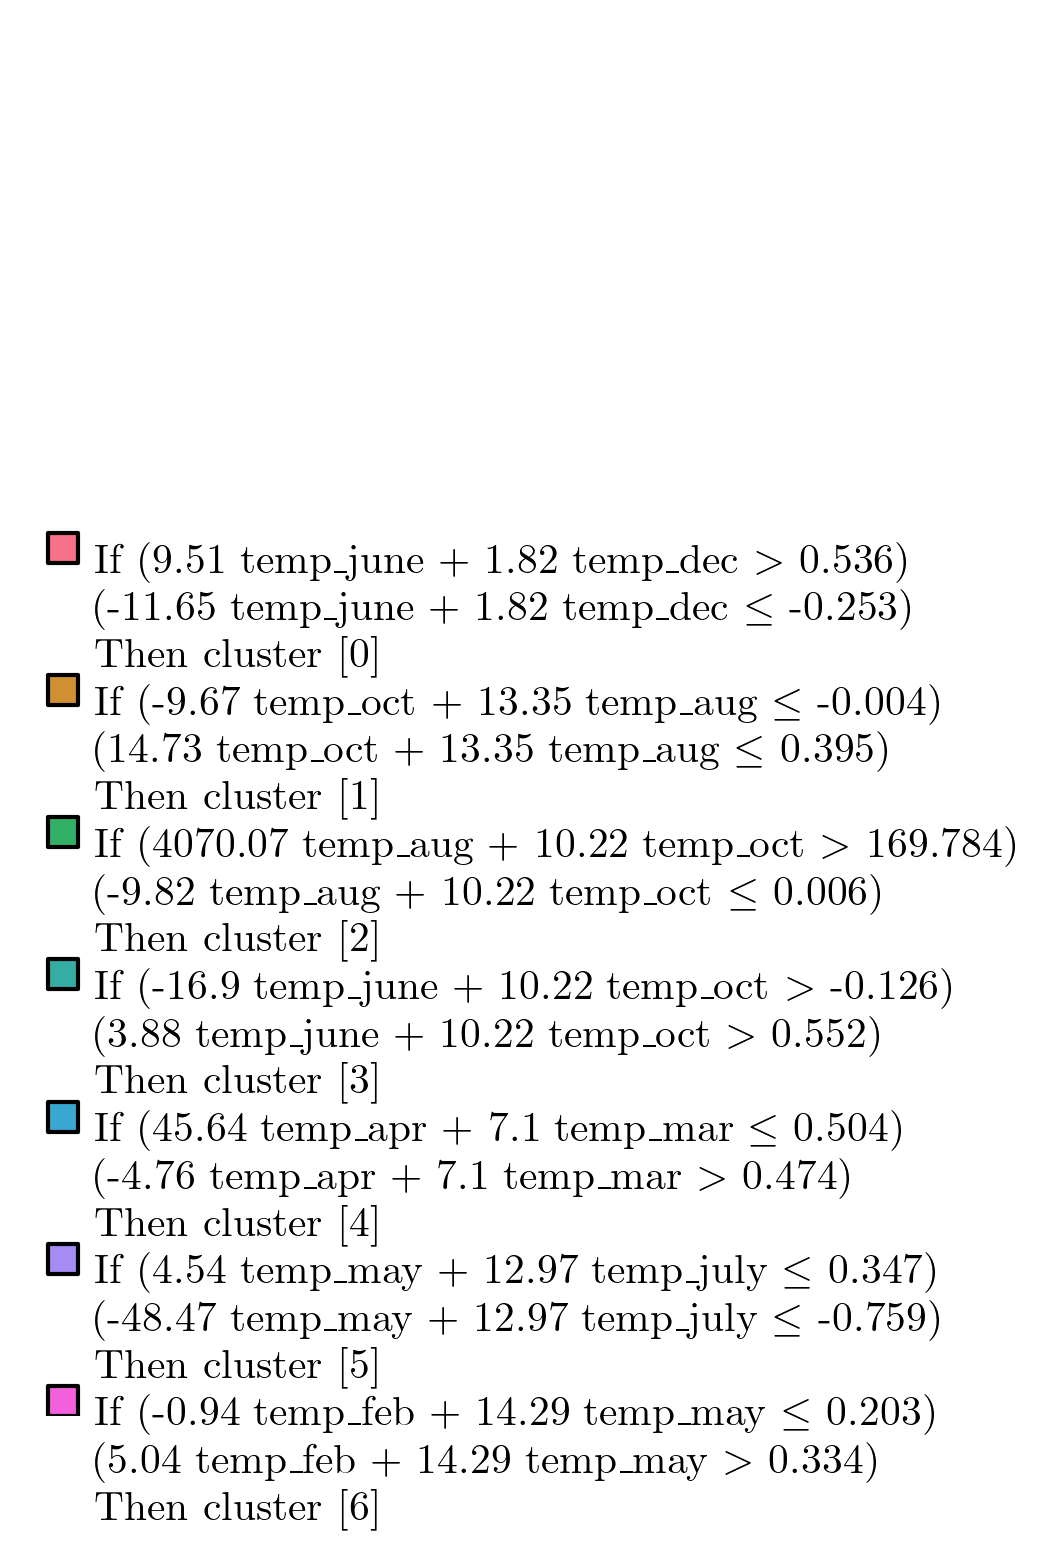

In [16]:
#fname = '../figures/climate/forest_rule_list.png'
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    [vor.decision_set[i] for i in vor.pruned_indices],
    feature_labels,
    [vor.decision_set_labels[i] for i in vor.pruned_indices],
    cluster_colors,
    data_scaler = scaler,
    filename = fname
)